# 주성분 분석

k-평균 알고리즘으로 업로드된 사진을 클러스터로 분류하여 폴더별로 저장  
그런데 너무 많은 사진이 등록되어 저장 공간이 부족함

## 차원과 차원 축소

우리는 데이터가 가진 속성을 특성이라고 부름  
머신러닝에서 이런 특성을 `차원`이라고도 부름  

차원을 줄이기 위해서 비지도 학습 작업 중 하나인 차원 축소 알고리즘을 사용  
차원 측소는 데이터를 가장 잘 나타내는 일부 특성을 선택하여 데이터 크기를 줄이고 지도 학습 모델의 성능을 향상시킬 수 있는 방법  
대표적인 차원 축소 알고리즘인 `주성분 분석(PCA)`

## PCA 클래스

In [1]:
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

components_속성에 PCA가 찾은 주성분을 저장,  
첫 번째는 지정한 값이고 두 번째는 원본 데이터의 특성 개수

In [3]:
print(pca.components_.shape)

(50, 10000)


In [4]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:   
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

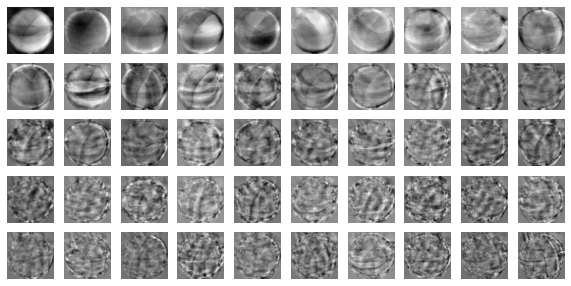

In [5]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

주성분은 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것  
주성분을 찾았으므로 원본 데이터를 주성분에 투영하여 특성의 개수를 10000개에서 50개로 줄일 수 있음  

In [6]:
print(fruits_2d.shape)

(300, 10000)


In [7]:
fruits_pca = pca.transform(fruits_2d)

In [8]:
print(fruits_pca.shape)

(300, 50)


## 원본 데이터 재구성

In [9]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


In [10]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

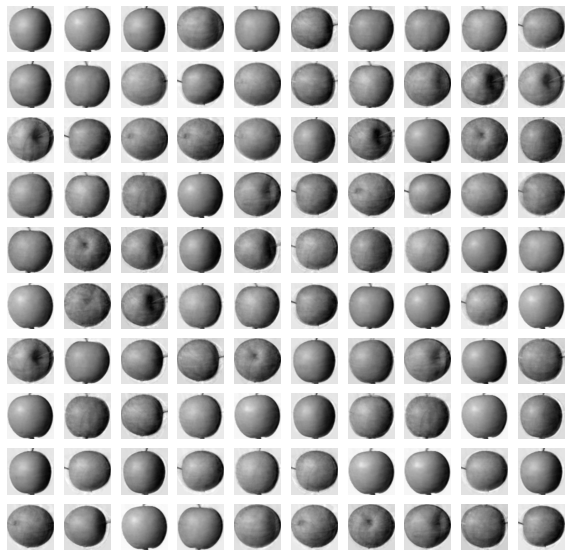

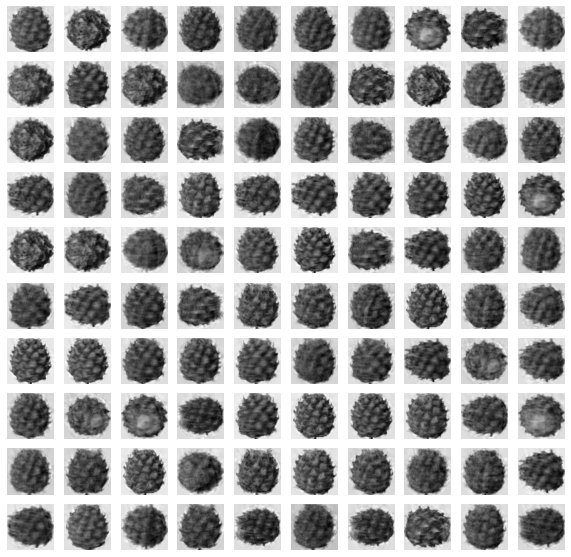

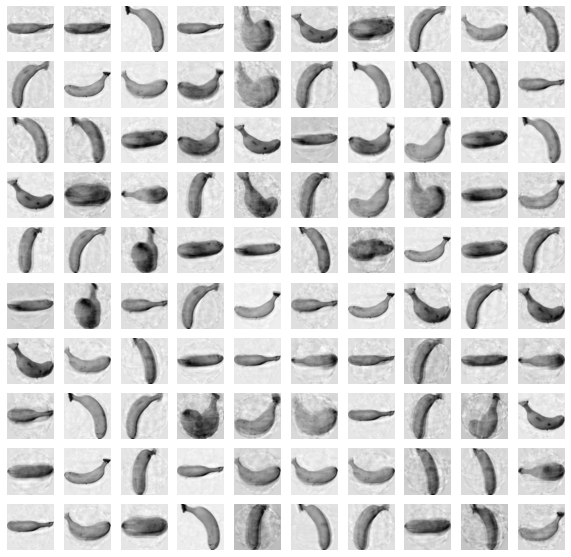

In [11]:
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

## 설명된 분산

주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 설명된 분산이라고 함

In [12]:
print(np.sum(pca.explained_variance_ratio_))

0.9215530648133423


92%가 넘는 분산을 유지  
앞에서 50개의 특성에서 원본 데이터를 복원했을 때 원본 이미지의 품질이 높았던 이유를 여기에서 찾을 수 있음

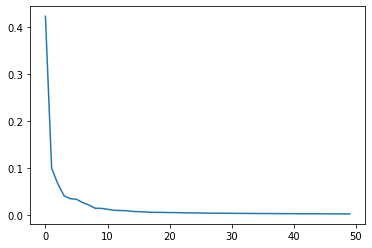

In [13]:
plt.plot(pca.explained_variance_ratio_)

10개의 주성분이 대부분의 분산을 표현

## 다른 알고리즘과 함께 사용하기

3개의 과일 사진을 분류해야 하므로 간단히 로지스틱 회귀 모델을 사용

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [15]:
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [16]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.4727729320526123


특성이 10000개나 되기 때문에 300개의 샘플에서는 과적합된 모델을 만들기 쉬움

In [17]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.03309788703918457


50개의 특성만 사용해도 100%이고 시간도 많이 단축됨

In [18]:
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [19]:
print(pca.n_components_)

2


In [20]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [21]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.99
0.04010157585144043


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [22]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

KMeans(n_clusters=3, random_state=42)

In [23]:
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2]), array([110,  99,  91], dtype=int64))


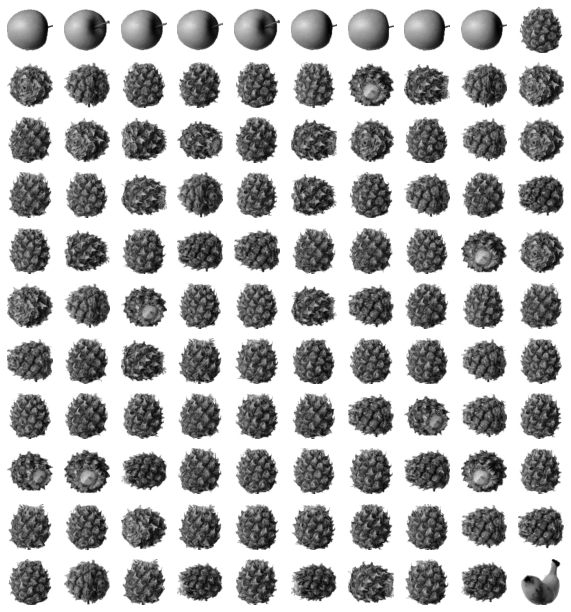

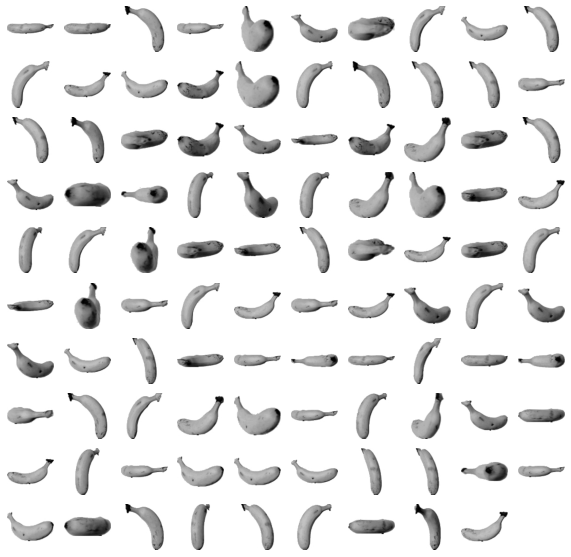

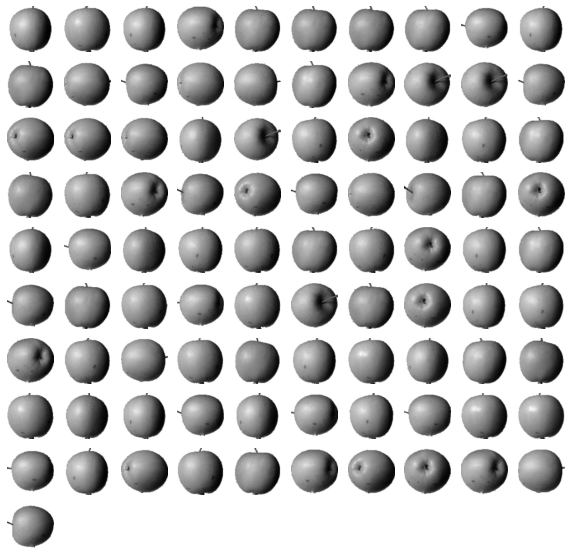

In [24]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

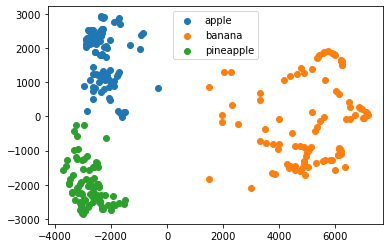

In [25]:
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

각 클러스터의 산점도가 아주 잘 구분됨  
2개의 특성만을 사용했는데 로지스틱 회귀 모델의 교차 검증 점수가 99%에 달하는 이유